In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/train_outliers.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4486312 entries, 0 to 4486311
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unnamed: 0              int64  
 1   building_id             int64  
 2   meter                   int64  
 3   timestamp               object 
 4   meter_reading           float64
 5   site_id                 int64  
 6   primary_use             object 
 7   square_feet             int64  
 8   floor_count             float64
 9   air_temperature         float64
 10  cloud_coverage          float64
 11  dew_temperature         float64
 12  precip_depth_1_hr       float64
 13  sea_level_pressure      float64
 14  wind_speed              float64
 15  hour                    int64  
 16  day                     int64  
 17  weekday                 int64  
 18  building_age            float64
 19  wind_compass_direction  float64
dtypes: float64(10), int64(8), object(2)
memory usage: 684.6+ MB


<AxesSubplot:>

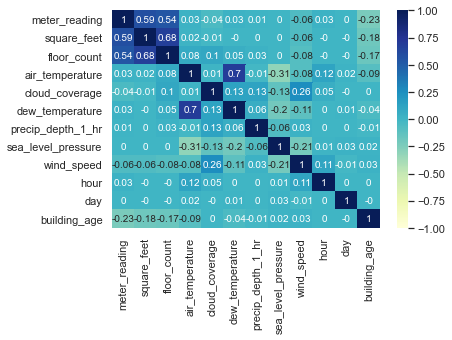

In [4]:
#Excluyo algunas variables para que sea más sencillo de leer
sns.heatmap(df.drop(["Unnamed: 0","meter","building_id","site_id","wind_compass_direction","weekday"],axis=1).corr().round(2), vmin=-1, vmax=1, center=0, cmap="YlGnBu",annot=True)

In [5]:
from sklearn.model_selection import train_test_split
y=df.meter_reading
X=df.drop(["Unnamed: 0","building_id","meter_reading","primary_use","meter","timestamp"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y)
#de la X excluyo la variable target, primary use and meter porque esán previamente filtradas, timestamp no es aplicable a este tipo de modelo,no excluyo por el momento las variables correlacionadas

In [6]:
import lightgbm as lgb
categorical_features = ['site_id','wind_compass_direction','weekday', 'hour',"day"]
model_lgb = lgb.LGBMRegressor(objective="regression",boosting= "gbdt",metric= "rmse",num_boost_round = 1000,verbose_eval = 100)

In [7]:
#No supe aplicar grid search
#from sklearn.model_selection import cross_val_score, StratifiedKFold
#cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)#from sklearn.model_selection import GridSearchCV
#params = {  
#   "n_estimators": [50,100,500]}
#grid_lgb = GridSearchCV(model_lgb, param_grid=params, cv=cv, verbose=1, n_jobs=-1)
#grid_lgb.fit(X_train,y_train)

In [8]:
model_lgb

LGBMRegressor(boosting='gbdt', metric='rmse', num_boost_round=1000,
              objective='regression', verbose_eval=100)

In [9]:
entreno=model_lgb.fit(X_train,y_train,categorical_feature=categorical_features)

In [10]:
pred=model_lgb.predict(X_train)

In [11]:
from sklearn import metrics

In [12]:
print ('R2:', metrics.r2_score(y_train, pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

R2: 0.9489534785523115
RMSE: 53.04246742133404


In [13]:
predtest=model_lgb.predict(X_test)

In [14]:
print ('R2test:', metrics.r2_score(y_test, predtest))
print ('RMSEtest:', np.sqrt(metrics.mean_squared_error(y_test, predtest)))

R2test: 0.9466762189001935
RMSEtest: 54.36356926443719


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

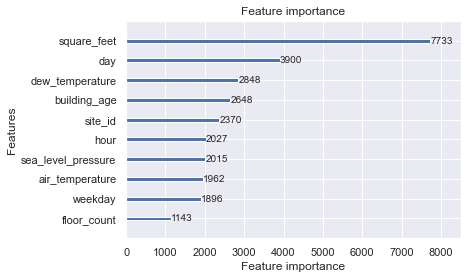

In [15]:
lgb.plot_importance(entreno, max_num_features=10)

[Text(0.5, 0, 'Predichos'), Text(0, 0.5, 'Observados')]

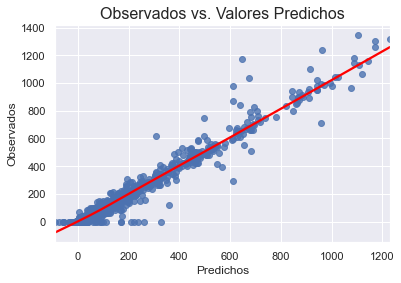

In [16]:
fig, ax = plt.subplots()

sns.regplot(x=predtest[0:1000], y=y_test[0:1000], lowess=True, line_kws={'color': 'red'})
ax.set_title('Observados vs. Valores Predichos', fontsize=16)
ax.set(xlabel='Predichos', ylabel='Observados')